#L* Demo with W-Method Oracle
Using the RNN extraction framework to extract DFA from Tomita Grammar 3

In [2]:
import sys
sys.path.append('/home/hayatokane/Lstar/rnn_extraction')

from extraction.dfa_extractor import DFAExtractor
from models.rnn_classifier import RNNClassifier
import torch
from IPython.display import Image, display
import subprocess
import json
from pathlib import Path

In [3]:
# Load model
checkpoint = torch.load('/home/hayatokane/Lstar/rnn_extraction/trained_models/tomita3_lstm_h50.pt', map_location='cpu')
config = checkpoint['model_config']

# Create model
model = RNNClassifier(
    alphabet_size=config['alphabet_size'],
    embedding_dim=config['embedding_dim'],
    hidden_dim=config['hidden_dim'],
    num_layers=config['num_layers'],
    rnn_type=config['rnn_type'],
    device='cpu'
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Loaded Tomita 3 model")

Loaded Tomita 3 model


In [4]:
# Extract DFA using W-method
# You can configure the oracle with oracle_params, otherwise default settings are used
oracle_params = {
    'max_target_states': 10  # Upper bound on number of states in target DFA (default: 10)
}

print("Extracting DFA with W-method oracle...")
print(f"Oracle configuration: {oracle_params}")
print("(If oracle_params is not specified, default values will be used)\n")

extractor = DFAExtractor(model, alphabet=['0', '1'])
dfa = extractor.extract(
    oracle_type='w_method', 
    oracle_params=oracle_params,  # Optional: specify oracle configuration
    time_limit=30,
    verbose=True  # Show detailed progress
)

Extracting DFA with W-method oracle...
Oracle configuration: {'max_target_states': 10}
(If oracle_params is not specified, default values will be used)

L* DFA Extraction
RNN Model: RNNClassifier
Alphabet: ['0', '1']
Time Limit: 30s
Oracle Type: w_method
Oracle Parameters: {'max_target_states': 10}

Starting example generation: checked 224 strings (224 queries)
  Positive examples: 113
  Negative examples: 111
  Selected starting examples: [('', True), ('10', False)]

Phase 2: L* Learning
------------------------------
Iteration 1: Constructed DFA with 1 states (refinement: 0.00s)

Equivalence query (iteration 1)
  Oracle type: w_method
  DFA states: 1

W-Method Equivalence Query (iteration 1)
  Hypothesis states: 1
  Test depth: 10 (max_target=10)
  Transition cover size: 2
  Characterization set size: 1
  Test set size: 4094
  Counterexample found: '10' (length 2)
  Strings checked: 3/4094
  Counterexample found: '10' (length 2, time: 0.00s)
  Counterexample found: '10' (length 2, se

In [24]:
# Print extraction statistics
if hasattr(extractor, 'extraction_stats'):
    stats = extractor.extraction_stats
    print("\nExtraction Statistics:")
    print(f"Total time: {stats.get('total_time', 0):.2f}s")
    if 'lstar_stats' in stats:
        lstar_stats = stats['lstar_stats']
        print(f"Iterations: {lstar_stats.get('iterations', 0)}")
        print(f"Hypotheses tested: {lstar_stats.get('hypotheses_tested', 0)}")
        print(f"Counterexamples: {lstar_stats.get('counterexamples', 0)}")
    if 'teacher_stats' in stats:
        teacher_stats = stats['teacher_stats']
        print(f"Membership queries: {teacher_stats.get('membership_queries', 0)}")
        print(f"Equivalence queries: {teacher_stats.get('equivalence_queries', 0)}")


Extraction Statistics:
Total time: 1.62s
Iterations: 3
Hypotheses tested: 3
Counterexamples: 2
Membership queries: 2065
Equivalence queries: 3



=== HYPOTHESIS EVOLUTION ===
Total hypotheses: 3

--- Hypothesis 1 ---
Iteration: 1
Time: 0.000s
States: 1


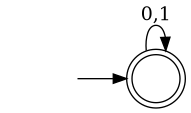

Rejected by counterexample: '10'
  RNN says: False
  DFA says: True

--- Hypothesis 2 ---
Iteration: 2
Time: 0.001s
States: 4


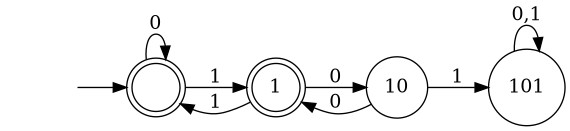

Rejected by counterexample: '10010'
  RNN says: False
  DFA says: True

--- Hypothesis 3 ---
Iteration: 3
Time: 0.006s
States: 5


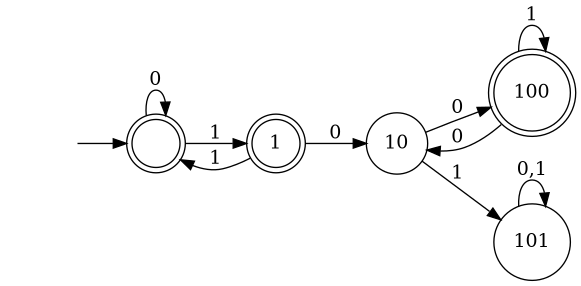

ACCEPTED - Final hypothesis



In [25]:
# Visualize learning history from the DFA object
learning_history = dfa.learning_history

print(f"\n=== HYPOTHESIS EVOLUTION ===")
print(f"Total hypotheses: {len(learning_history)}\n")

for i, hyp in enumerate(learning_history):
    print(f"--- Hypothesis {i+1} ---")
    print(f"Iteration: {hyp.get('iteration', i+1)}")
    print(f"Time: {hyp.get('time', 0):.3f}s")
    print(f"States: {hyp.get('states', 'N/A')}")
    
    # Get the DFA object
    if 'dfa_object' in hyp:
        # Generate visualization
        dot = hyp['dfa_object'].to_dot()
        filename = f'hypothesis_{i+1}'
        with open(f'{filename}.dot', 'w') as f:
            f.write(dot)
        subprocess.run(['dot', '-Tpng', f'{filename}.dot', '-o', f'{filename}.png'])
        
        # Display the hypothesis
        display(Image(f'{filename}.png'))
        
        # Show counterexample if it exists
        if hyp.get('counterexample'):
            ce_info = hyp['counterexample']
            print(f"Rejected by counterexample: '{ce_info['string']}'")
            print(f"  RNN says: {ce_info['rnn_label']}")
            print(f"  DFA says: {ce_info['dfa_label']}")
        else:
            print("ACCEPTED - Final hypothesis")
    print()